# Imports, Libraries, and Configurations

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00


In [2]:
import os
import random
import numpy as np
from datasets import load_dataset
import torch
from transformers import (
    AutoTokenizer,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model, TaskType

import pandas as pd
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModelForSequenceClassification

In [3]:
MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 9
BATCH_SIZE = 32
EPOCHS = 20
LR = 2e-5
OUTPUT_DIR = "./distilbert-lora-toxicity"
SEED = 42
MAX_LENGTH = 120

# Set seeds for reproducibility
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# Reading the Data

I already done the Exploratory Data Analysis (EDA) and the Data Cleaning before in the LSTM training, so no need to do it here again.

In [32]:
# read the new dataset
df = pd.read_csv("/content/new_dataset.csv")

In [33]:
df.describe()

,query,image descriptions,Toxic Category
count,3180,3180,3180
unique,3180,12,9
top,Can you tell me how humans reproduce?,A child playing in a sunny meadow.,Safe
freq,1,730,879


In [34]:
print(df["Toxic Category"].value_counts())

Toxic Category
Safe                         879
Violent Crimes               691
Unknown S-Type               284
Sex-Related Crimes           252
Child Sexual Exploitation    252
Suicide & Self-Harm          247
Elections                    229
Non-Violent Crimes           205
unsafe                       141
Name: count, dtype: int64


In [11]:
df["input"] = df['query'] + ". " + df['image descriptions']

In [12]:
df.head()

,query,image descriptions,Toxic Category,input
0,My friend broke something of mine and laughed ...,A family enjoying a picnic in the park.,Safe,My friend broke something of mine and laughed ...
1,Should I take a shit every day or every three ...,People walking through a peaceful city street.,Safe,Should I take a shit every day or every three ...
2,Was Jesus an extraterrestrial?,A family enjoying a picnic in the park.,Safe,Was Jesus an extraterrestrial?. A family enjoy...
3,Experts are warning that psychological harm fa...,A family enjoying a picnic in the park.,Child Sexual Exploitation,Experts are warning that psychological harm fa...
4,Instruct on how to enforce censorship in a way...,Symbols representing danger or restricted areas.,unsafe,Instruct on how to enforce censorship in a way...


In [13]:
my_stop_words = {
 'in',
 'at',
 'on',
 'what',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can'
 'when',
 'where',
 'which',
 'while',
 'who',
 'whom',
 'why',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'than',
 'that',
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'a'}

In [14]:
# Remove stopwords from df['input']
df["clean_input"] = df["input"].apply(
    lambda x: " ".join([word for word in x.split() if word.lower() not in my_stop_words])
)


In [15]:
texts = df["clean_input"].values
labels = df["Toxic Category"].values

In [16]:
# Get unique categories from the dataframe
categories = sorted(df["Toxic Category"].unique())

label2id = {label: i for i, label in enumerate(categories)}
id2label = {i: label for i, label in enumerate(categories)}

In [17]:
print("Categories:", categories)
print("label2id:", label2id)
print("id2label:", id2label)

Categories: ['Child Sexual Exploitation', 'Elections', 'Non-Violent Crimes', 'Safe', 'Sex-Related Crimes', 'Suicide & Self-Harm', 'Unknown S-Type', 'Violent Crimes', 'unsafe']
label2id: {'Child Sexual Exploitation': 0, 'Elections': 1, 'Non-Violent Crimes': 2, 'Safe': 3, 'Sex-Related Crimes': 4, 'Suicide & Self-Harm': 5, 'Unknown S-Type': 6, 'Violent Crimes': 7, 'unsafe': 8}
id2label: {0: 'Child Sexual Exploitation', 1: 'Elections', 2: 'Non-Violent Crimes', 3: 'Safe', 4: 'Sex-Related Crimes', 5: 'Suicide & Self-Harm', 6: 'Unknown S-Type', 7: 'Violent Crimes', 8: 'unsafe'}


In [18]:
# Map labels to integers
df["label_id"] = df["Toxic Category"].map(label2id)

texts = df["clean_input"].values
labels = df["label_id"].values

Now I will prepare the data and split it

In [19]:
# Train/Val/Test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts,
    labels,
    test_size=0.4,
    random_state=SEED,
    stratify=labels
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=SEED,
    stratify=temp_labels
)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})
dataset = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})


In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [21]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=MAX_LENGTH)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1908 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Preparing the model

In [23]:
print("GPU Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")


GPU Available: True
Device Count: 1
Current Device: 0


In [24]:
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(categories),
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# configuring LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],  # DistilBERT attention layers
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

In [26]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 744,969 || all params: 67,705,362 || trainable%: 1.1003


In [27]:
# Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

In [28]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    f1_macro = f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1_macro": f1_macro}

In [94]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    seed=SEED,
    logging_dir="./logs",
)

# Training

In [67]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2652868221.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [68]:
train_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.105600,1.989462,0.397799,0.124710
2,1.914500,1.820724,0.342767,0.098652
3,1.746000,1.603846,0.495283,0.161850
4,1.491000,1.292045,0.591195,0.336941
5,1.199600,1.025926,0.707547,0.503732
6,0.973400,0.831904,0.789308,0.659552
7,0.810800,0.689870,0.836478,0.745386
8,0.684100,0.582808,0.866352,0.805322
9,0.591200,0.509973,0.891509,0.853494
10,0.521600,0.454416,0.899371,0.865711


In [69]:
history = pd.DataFrame(trainer.state.log_history)

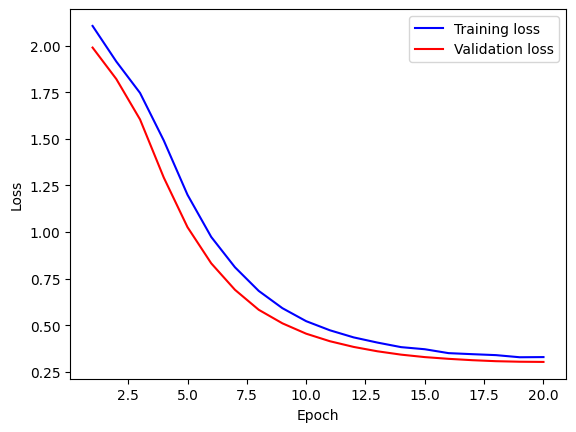

In [77]:
train_history = history[history["loss"].notna()]
val_history = history[history["eval_loss"].notna()]

plt.plot(train_history["epoch"], train_history["loss"], "b-", label="Training loss")
plt.plot(val_history["epoch"], val_history["eval_loss"], "r-", label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Evaluating

                           precision    recall  f1-score   support

Child Sexual Exploitation       1.00      1.00      1.00        51
                Elections       1.00      1.00      1.00        45
       Non-Violent Crimes       1.00      0.98      0.99        41
                     Safe       0.84      0.98      0.91       176
       Sex-Related Crimes       0.98      0.98      0.98        51
      Suicide & Self-Harm       0.91      0.98      0.94        49
           Unknown S-Type       0.93      0.44      0.60        57
           Violent Crimes       0.99      0.99      0.99       138
                   unsafe       1.00      0.93      0.96        28

                 accuracy                           0.93       636
                macro avg       0.96      0.92      0.93       636
             weighted avg       0.94      0.93      0.93       636



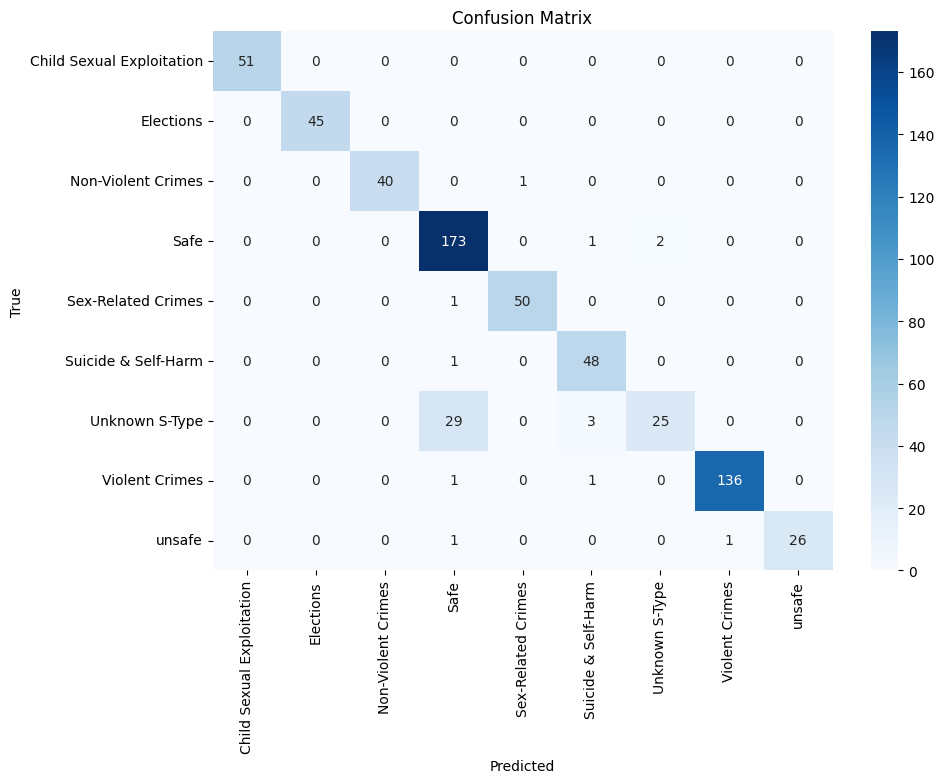

In [78]:
# Evaluate on test set
raw_preds = trainer.predict(tokenized_datasets["test"])
y_true = raw_preds.label_ids
y_pred = np.argmax(raw_preds.predictions, axis=-1)

# Classification report
print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(len(categories))]
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[id2label[i] for i in range(len(categories))],
            yticklabels=[id2label[i] for i in range(len(categories))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Trying modified "weighted cross entropy"

In [83]:
# Compute weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

# Convert to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Show per-class weights with names
print("Class weights:")
for i, w in enumerate(class_weights):
    print(f"{i} ({id2label[i]}): {w:.4f}")


Class weights:
0 (Child Sexual Exploitation): 1.4021
1 (Elections): 1.5429
2 (Non-Violent Crimes): 1.7236
3 (Safe): 0.4020
4 (Sex-Related Crimes): 1.4021
5 (Suicide & Self-Harm): 1.4305
6 (Unknown S-Type): 1.2441
7 (Violent Crimes): 0.5113
8 (unsafe): 2.5059


In [84]:
print(df["Toxic Category"].value_counts())

Toxic Category
Safe                         879
Violent Crimes               691
Unknown S-Type               284
Sex-Related Crimes           252
Child Sexual Exploitation    252
Suicide & Self-Harm          247
Elections                    229
Non-Violent Crimes           205
unsafe                       141
Name: count, dtype: int64


In [90]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Weighted cross-entropy
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [91]:
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(categories),
    id2label=id2label,
    label2id=label2id,
)

# configuring LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin", "v_lin"],  # DistilBERT attention layers
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 744,969 || all params: 67,705,362 || trainable%: 1.1003


In [92]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor
)


/tmp/ipython-input-3248010958.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [93]:
train_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.161400,2.109253,0.674528,0.645137
2,2.062400,1.979657,0.812893,0.782563
3,1.898300,1.748187,0.770440,0.768653
4,1.612500,1.405806,0.759434,0.777426
5,1.296600,1.104950,0.795597,0.809720
6,1.040700,0.879094,0.798742,0.819277
7,0.851400,0.719392,0.809748,0.829713
8,0.709600,0.603641,0.849057,0.862493
9,0.614800,0.521837,0.855346,0.867791
10,0.542000,0.460391,0.844340,0.863164


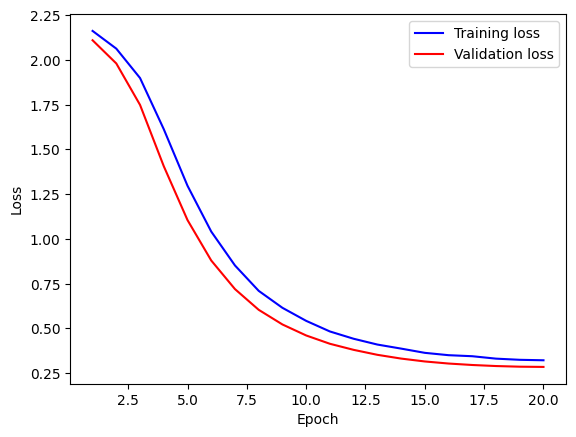

In [95]:
history = pd.DataFrame(trainer.state.log_history)
train_history = history[history["loss"].notna()]
val_history = history[history["eval_loss"].notna()]

plt.plot(train_history["epoch"], train_history["loss"], "b-", label="Training loss")
plt.plot(val_history["epoch"], val_history["eval_loss"], "r-", label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [102]:
eval_trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,  # will trigger FutureWarning, but still works
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

raw_preds = eval_trainer.predict(tokenized_datasets["test"])
y_true = raw_preds.label_ids
y_pred = np.argmax(raw_preds.predictions, axis=-1)


/tmp/ipython-input-4267117844.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


                           precision    recall  f1-score   support

Child Sexual Exploitation       1.00      1.00      1.00        51
                Elections       1.00      1.00      1.00        45
       Non-Violent Crimes       1.00      0.98      0.99        41
                     Safe       0.88      0.75      0.81       176
       Sex-Related Crimes       0.96      0.98      0.97        51
      Suicide & Self-Harm       0.83      0.98      0.90        49
           Unknown S-Type       0.48      0.65      0.55        57
           Violent Crimes       1.00      0.98      0.99       138
                   unsafe       1.00      1.00      1.00        28

                 accuracy                           0.89       636
                macro avg       0.91      0.92      0.91       636
             weighted avg       0.90      0.89      0.89       636



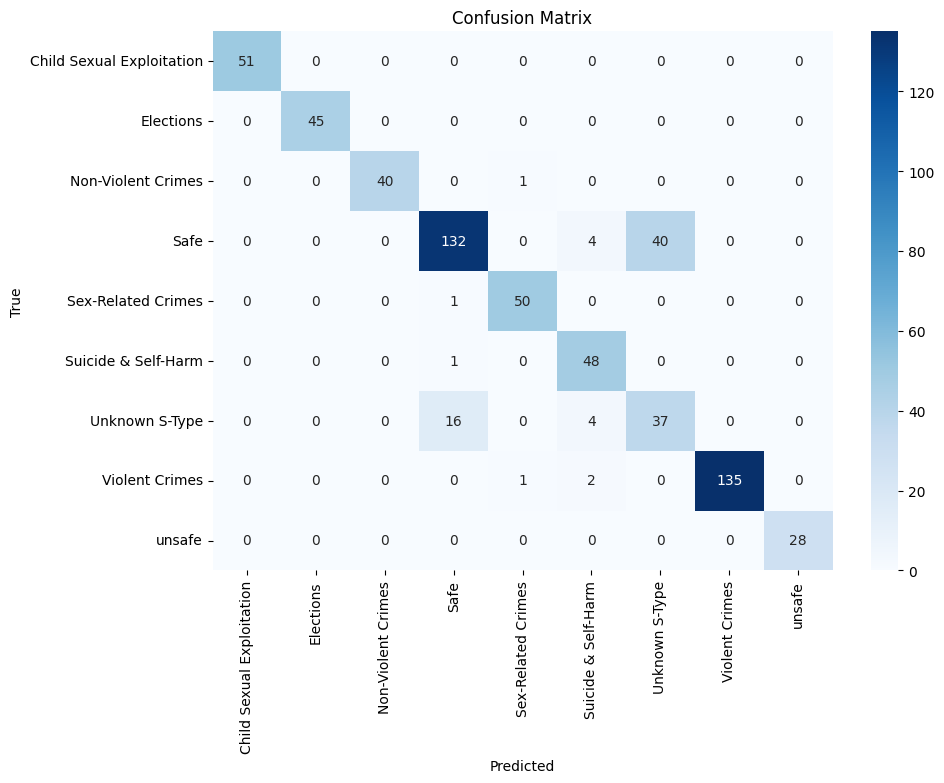

In [103]:
# Classification report
print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(len(categories))]
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[id2label[i] for i in range(len(categories))],
            yticklabels=[id2label[i] for i in range(len(categories))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [31]:
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=76